## Issues:
* CRITICAL: Solve the edge issues where FEM nodes are accidentally very close to boundary elements.
* MEDIUM: It's pretty dang slow even when the number of elements is not high. I think 10-20x speedup is possible with some smart code. 
    * Optimize by removing redundant calculations from calc_dVdt.
    * Optimize by reducing calc_dVdt to a series of matrix vector product or similar. Currently, the interior evaluation and projections are slow and could be optimized a lot.
    * https://fenicsproject.org/qa/1899/fast-projection-in-case-of-explicit-relations/
    * It looks like there's currently no solution to evaluate at many interior points at once: https://fenicsproject.org/qa/6374/what-is-the-best-way-to-evaluate-function-in-list-coordinates/
    * It's possible that we'd be better plotting at FEM mesh nodes. 
* Better time stepping, figure out a good step size. 

## Resources
* Useful website: https://comet-fenics.readthedocs.io/en/latest/
* Useful post: https://comet-fenics.readthedocs.io/en/latest/demo/viscoelasticity/linear_viscoelasticity.html
* Useful post: https://comet-fenics.readthedocs.io/en/latest/demo/elastodynamics/demo_elastodynamics.py.html

### Derivation

Let's start from the constitutive equation for elasticity and the constitutive equation for a Maxwell rheology. We'll do this in full 3D complexity and then reduce to plane-strain later.

$$\textrm{Elastic:  }~~ \sigma_{ij} = 2\mu\epsilon_{ij} + \lambda\epsilon_{kk}\delta_{ij}$$
$$\textrm{Maxwell:  }~~ \dot{\sigma}_{ij} + \frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij}) = 2\mu\dot{\epsilon}_{ij} + \lambda\dot{\epsilon}_{kk}\delta_{ij}$$

And Newton's law:

$$ \frac{\partial \sigma_{ij}}{\partial x_j} = f_i $$

So, for an elastic rheology:

$$ \frac{\partial [2\mu\epsilon_{ij} + \lambda\epsilon_{kk}\delta_{ij}]}{\partial x_j} = f_i $$

For a viscoelastic rheology, remembering the time derivative: $\dot{\sigma}_{ij}$:

$$ \frac{\partial \big[2\mu\dot{\epsilon}_{ij} + \lambda\dot{\epsilon}_{kk}\delta_{ij} - [\frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij})]\big]}{\partial x_j} = \dot{f}_i $$

Rearranging the viscoelastic equation: 

$$ \frac{\partial \big[2\mu\dot{\epsilon}_{ij} + \lambda\dot{\epsilon}_{kk}\delta_{ij}\big]}{\partial x_j} = \dot{f}_i  + \frac{\partial[\frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij})]}{\partial x_j} $$

Rewriting the right hand side as $F_i$, we see that this is an elastic problem with a funny body force:

$$ \textrm{"Elastic-like": }~~ \frac{\partial \big[2\mu\dot{\epsilon}_{ij} + \lambda\dot{\epsilon}_{kk}\delta_{ij}\big]}{\partial x_j} = F_i$$
$$ \textrm{"Viscoelastic body force": }~~ F_i = \dot{f}_i + \frac{\partial[\frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij})]}{\partial x_j} $$

It's important to notice that in the main "Elastic-like" equation, we are operating in terms of velocity/strain-rate/stressing-rate because the whole equation has had a time derivative applied. 

So, how do we solve this? I see two broad ways depending on where we would prefer to do the time integration. 

1. Compute velocities and stressing rates at each time step and then integrate those to obtain displacement and stress. 
2. Integrate the "Elastic-like" equation analytically (trivial, since it just involves removing some dots), so that we can solve directly for displacement and stress then do a time integration to compute the current viscoelastic body force. 

I think method #2 is likely to be more accurate and stable simply because it involves lower order derivatives. Instead of integrating stressing rate in time to get stress, we are integrating stress in time to get the total viscoelastic body force. To do this, let's define:

$$ V = \int_{0}^{t}\frac{\partial[\frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij})]}{\partial x_j} dt $$

and rearrange this to involve a time step:

$$ V^{n+1}_i = V^{n}_i + \int_{t^n}^{t^{n+1}} \frac{\partial[\frac{\mu}{\eta}(\sigma_{ij} - \frac{\sigma_{kk}}{3}\delta_{ij})]}{\partial x_j} dt$$

Returning to the main law of motion:

$$\frac{\partial \sigma_{ij}^{n}}{\partial x_j} = f^{n}_i + V^{n}_i$$

So, what's the final solution procedure?

1. Given $V_i^n$, solve the law of motion for stress, $\sigma_{ij}$, and displacement $u_i$.
2. Now, integrate the time step equation above to get $V_i^{n+1}$. 

In [2]:
using Revise
using PyPlot
using Infiltrator
using LinearAlgebra
using Bem2d
using PyCall
using FEniCS

In [3]:
include("Helpers.jl")

twopanel (generic function with 1 method)

In [4]:
mu = 30e9
lambda = 30e9
eta = 1e19 # just made up a number!
VE_z = -16e3 # Depth below which we use a Maxwell rheology
nu = 0.25
g = 9.81
rho = 2700
siay = 3600 * 24 * 365.2425

3.1556952e7

In [5]:
# Element geometries and data structures 
elsbox = Elements(Int(1e5))

# Box geometry
B = -50e3 # Bottom
R = 20e3 # Right
T = 0e3 # Top
L = -20e3; # Left
nside = 50 # number of elements per box side

addelsez!(elsbox, discretizedline(L, B, R, B, nside)..., "B")
addelsez!(elsbox, discretizedline(R, B, R, T, nside)..., "R")
addelsez!(elsbox, discretizedline(R, T, L, T, nside)..., "T")
addelsez!(elsbox, discretizedline(L, T, L, B, nside)..., "L")

# Fault geometry
nfault = 1
x1, y1, x2, y2 = discretizedline(-10e3, -10e3, -5e3, -5e3, nfault) # 45 degree dipping fault
addelsez!(elsbox, x1, y1, x2, y2, "F")

idx = getidxdict(elsbox);
BRTL_idx = [idx["B"] ; idx["R"] ; idx["T"] ; idx["L"]]
RTL_idx = [idx["R"] ; idx["T"] ; idx["L"]];

getidx found 50 elements with label "B"
getidx found 50 elements with label "R"
getidx found 50 elements with label "T"
getidx found 50 elements with label "L"
getidx found 1 elements with label "F"


In [6]:
npts = 50
offset = 1
xgrid, ygrid = obsgrid(L+offset, B+offset, R-offset, T-offset, npts);

In [7]:
### Slip from fault only
T_TB_F, H_TB_F = PUTC(slip2dispstress, elsbox, BRTL_idx, idx["F"], mu, nu)
Fslip = [100; 100]; # y-direction slip only
Uslip = T_TB_F * Fslip
Tslip = H_TB_F * Fslip;

In [8]:
# Kernels and solve
T_B_BRTL, H_B_BRTL = PUTC(slip2dispstress, elsbox, idx["B"], BRTL_idx, mu, nu)
T_RTL_BRTL, H_RTL_BRTL = PUTC(slip2dispstress, elsbox, RTL_idx, BRTL_idx, mu, nu)
bcs_fault_only = zeros(8 * nside)
bcs_fault_only[1:2*nside] = -Uslip[1:2*nside] # Bottom
bcs_fault_only[2*nside+1:4*nside] = -Tslip[2*nside+1:4*nside] # Right
bcs_fault_only[4*nside+1:6*nside] = -Tslip[4*nside+1:6*nside] # Top
bcs_fault_only[6*nside+1:8*nside] = -Tslip[6*nside+1:8*nside] # Left
THbox = [T_B_BRTL ; H_RTL_BRTL];

In [9]:
THboxinv = inv(THbox);

Plot the displacements and stress from just the fault motion.

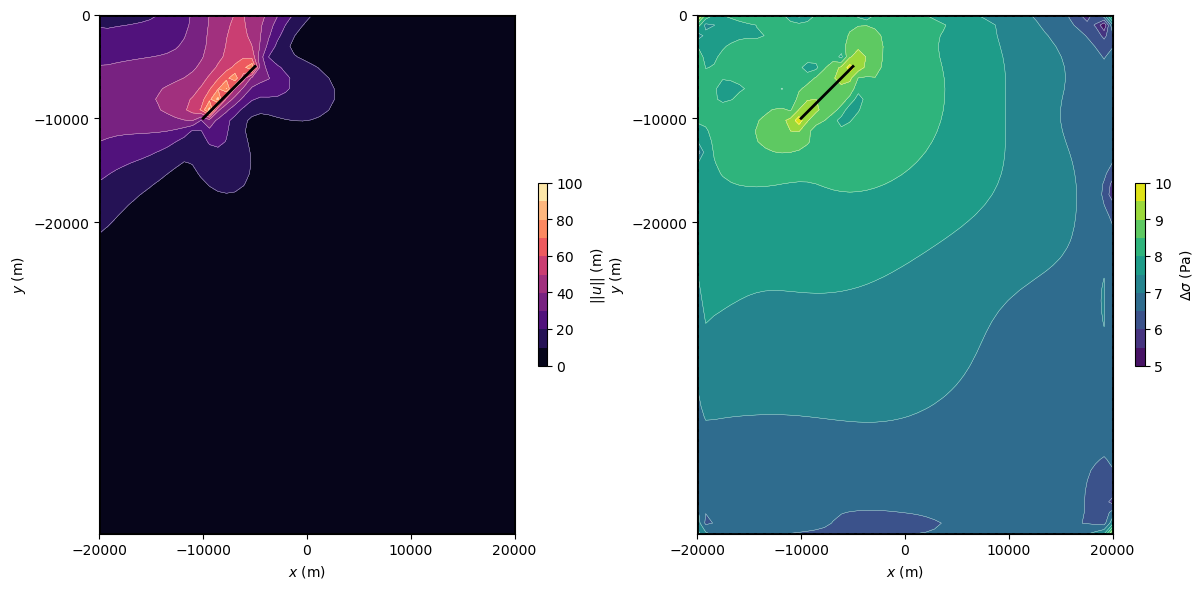

In [10]:
Ueff_fault_only = THbox \ bcs_fault_only
UTB, STB = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, BRTL_idx,
                           Ueff_fault_only[1:2:end], Ueff_fault_only[2:2:end], mu, nu)
UF, SF = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, idx["F"],
                         Fslip[1:2:end], Fslip[2:2:end], mu, nu)
Ufaultonly = UTB .+ UF
Sfaultonly = STB .+ SF
twopanel(xgrid, ygrid, npts, Ufaultonly, Sfaultonly, idx, elsbox, figsize=(12,6), ylim=[B,T]);

In [20]:
fenics_mesh = RectangleMesh(Point((L - 5000, T + 5000)), Point((R + 5000, B - 5000)), 60, 60)
scalar_fs = FunctionSpace(fenics_mesh, "P", 1)
vector_fs = VectorFunctionSpace(fenics_mesh, "P", 2)
tensor_fs = FunctionSpace(FEniCS.fenics.TensorFunctionSpace(fenics_mesh.pyobject, "P", 1))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


"FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 8728), TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}))"

In [21]:
include("Helpers.jl")

x_dofs = py"lambda x: x.tabulate_dof_coordinates()"(scalar_fs.pyobject);
_, stress_from_fault = constdispstress(slip2dispstress, x_dofs[:,1], x_dofs[:,2], elsbox, idx["F"],
                                       Fslip[1:2:end], Fslip[2:2:end], mu, nu)

# no viscous behavior in the surface layer, mu/eta below VE_z
# We can't use a threshold for eta because we divide by eta and dividing by zero is bad.
fenics_mu_over_eta = interpolate(Expression("0.0 + mu/eta*(x[1] <= VE_z)", degree=0, mu=mu, eta=eta, VE_z=VE_z), scalar_fs)
fenics_Ve = FeFunction(vector_fs)
fenics_disp = FeFunction(vector_fs)

v = TestFunction(vector_fs)
bc = DirichletBC(vector_fs, Constant((0, 0)), "on_boundary")
function fenics_lhs_assemble(V)
    u = TrialFunction(V)
    a = inner(fenics_stress(u, lambda, mu), fenics_strain(v)) * dx
    A = assemble(a)
    apply(bc, A)
    A
end
function fenics_rhs_assemble(V, f)
    L = FEniCS.dot(f, v) * dx
    b = assemble(L)
    apply(bc, b)
    b
end
lhs = fenics_lhs_assemble(vector_fs)
lu_solver = py"""
from fenics import *
def create_lu_solver(lhs):
    s = LUSolver(lhs, method='umfpack')
    s.parameters['symmetric'] = True
    return s
"""
lu_solver = py"create_lu_solver"(lhs.pyobject)
function fenics_lu_solve(lu_solver, u, rhs)
    py"lambda lu_solver, u, rhs: lu_solver.solve(u.vector(), rhs)"(lu_solver, u.pyobject, rhs.pyobject)
end

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


fenics_lu_solve (generic function with 1 method)

In [22]:
# Step 1: solve FEM+BEM problem
function solve_elastic_problem(dofs)
    vector(fenics_Ve).set_local(dofs)
    rhs = fenics_rhs_assemble(vector_fs, fenics_Ve)
    fenics_lu_solve(lu_solver, fenics_disp, rhs)
        
    fenics_sigma = fenics_stress(fenics_disp, lambda, mu)
    sxx_sxy, sxy_syy = fenics_tensor_components(vector_fs, fenics_sigma)

    bcs_B = -fenics_eval_u(fenics_disp, idx["B"], elsbox.xcenter, elsbox.ycenter)
    bcs_RTL_S = -fenics_eval_s(sxx_sxy, sxy_syy, RTL_idx, elsbox.xcenter, elsbox.ycenter)
    bcs_RTL = stress_to_trac(bcs_RTL_S, RTL_idx, elsbox.xnormal, elsbox.ynormal);

    bcs_ve_fem = zeros(2 * elsbox.endidx - 2)
    bcs_ve_fem[1:2*nside] = bcs_B
    bcs_ve_fem[2*nside+1:end] = bcs_RTL;

    bcscombined = bcs_fault_only .+ bcs_ve_fem    
    Ueffcombined = THbox \ bcscombined
    
    fenics_sigma, Ueffcombined
end

# Step 2: convert BEM stress to a fenics object
# Three sources of stress: u_eff, fault, FEM
function calc_total_stress(fenics_sigma, Ueffcombined)
    _, stress_from_ueff = constdispstress(slip2dispstress, x_dofs[:,1], x_dofs[:,2], elsbox, BRTL_idx,
                                          Ueffcombined[1:2:end], Ueffcombined[2:2:end], mu, nu)
    total_bem_stress = stress_from_ueff .+ stress_from_fault
    
    # set stress values to zero when they are outside the box domain. TODO: I don't think this is right solution even though it's easy.
    total_bem_stress[x_dofs[:,1] .<= L, :] .= 0
    total_bem_stress[x_dofs[:,1] .>= R, :] .= 0
    total_bem_stress[x_dofs[:,2] .<= B, :] .= 0
    total_bem_stress[x_dofs[:,2] .>= T, :] .= 0

    fenics_stress_dofs = zeros(4,size(x_dofs)[1])
    fenics_stress_dofs[1,:] = total_bem_stress[:,1]
    fenics_stress_dofs[2,:] = total_bem_stress[:,3]
    fenics_stress_dofs[3,:] = total_bem_stress[:,3]
    fenics_stress_dofs[4,:] = total_bem_stress[:,2];
    bem_sigma = FeFunction(tensor_fs)
    vector(bem_sigma).set_local(reshape(fenics_stress_dofs, (:)))
    total_sigma = bem_sigma + fenics_sigma
end

# Step 3: calculate the stress deviator and dVdt. Extract dofs from fenics function and return the array.
function stress_to_dVdt(total_sigma)
    # https://en.wikipedia.org/wiki/Cauchy_stress_tensor#Stress_deviator_tensor
    stress_deviator = total_sigma - (1.0/3)*FEniCS.tr(total_sigma)*Identity(2);
    dVdt = project(fenics_mu_over_eta * div(stress_deviator), vector_fs)
    vector(dVdt).get_local()
end

function volume_disp_stress(Ueffcombined)
    UTB, STB = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, BRTL_idx,
                               Ueffcombined[1:2:end], Ueffcombined[2:2:end], mu, nu)
            
    fenics_sigma = fenics_stress(fenics_disp, lambda, mu)
    sxx_sxy, sxy_syy = fenics_tensor_components(vector_fs, fenics_sigma)
    
    Ufem = transpose(reshape(fenics_eval_u(fenics_disp, 1:length(xgrid), xgrid, ygrid), (2,:)))
    Sfem = transpose(reshape(fenics_eval_s(sxx_sxy, sxy_syy, 1:length(xgrid), xgrid, ygrid), (3,:)));
    
    Utotal = UTB .+ UF .+ Ufem
    Stotal = STB .+ SF .+ Sfem
    Utotal, Stotal
end

volume_disp_stress (generic function with 1 method)

In [23]:
function calc_dVdt(Ve_force_dofs)
    fenics_sigma, Ueffcombined = solve_elastic_problem(Ve_force_dofs)
    total_sigma = calc_total_stress(fenics_sigma, Ueffcombined)
    dVdt  = stress_to_dVdt(total_sigma)
    dVdt, Ueffcombined
end

calc_dVdt (generic function with 1 method)

Integrate for 200 years after our 141m fault slip event (HUGE EARTHQUAKE).

In [24]:
V = zeros(vector(fenics_Ve).size())
dt = siay * 2
t = 0
Uhistory = []
for i in 1:100
    println(t)
    dVdt, Ueffcombined = calc_dVdt(V)
    V += dt .* dVdt
    t += dt
    Utotal, Stotal = volume_disp_stress(Ueffcombined)
    append!(Uhistory, [Utotal])
    #@time twopanel(xgrid, ygrid, npts, Utotal, Stotal, idx, elsbox, figsize=(12,6), ylim=[B,T]);
end
Uhistory = reshape(hcat(Uhistory...), (:, 2, length(Uhistory)));

0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
6.3113904e7
1.26227808e8
1.89341712e8
2.52455616e8
3.1556952e8
3.78683424e8
4.41797328e8
5.04911232e8
5.68025136e8
6.3113904e8
6.94252944e8
7.57366848e8
8.20480752e8
8.83594656e8
9.4670856e8
1.009822464e9
1.072936368e9
1.136050272e9
1.199164176e9
1.26227808e9
1.325391984e9
1.388505888e9
1.451619792e9
1.514733696e9
1.5778476e9
1.640961504e9
1.704075408e9
1.767189312e9
1.830303216e9
1.89341712e9
1.956531024e9
2.019644928e9
2.082758832e9
2.145872736e9
2.20898664e9
2.272100544e9
2.335214448e9
2.398328352e9
2.461442256e9
2.52455616e9
2.587670064e9
2.650783968e9
2.713897872e9
2.777011776e9
2.84012568e9
2.903239584e9
2.966353488e9
3.029467392e9
3.092581296e9
3.1556952e9
3.218809104e9
3.281923008e9
3.345036912e9
3.408150816e9
3.4712

In [25]:
# sanity check: velocity measured in mm/yr
Vhistory = (Uhistory[:,:,2:end] - Uhistory[:,:,1:end-1]) ./ dt * siay * 1000;

In [47]:
maxV = dropdims(maximum(sqrt.(Vhistory[:,1,:].^2 + Vhistory[:,2,:].^2), dims=(1)), dims=(1));

First check... Looks like the velocity decays logarithmically as expected! 

In [48]:
maxV

99-element Array{Float64,1}:
 991.3659701133049  
 846.9204170464335  
 728.2927722039835  
 630.2444532110204  
 548.6666759054764  
 480.331937699099   
 422.6996261886645  
 373.76435584314606 
 331.93809447530225 
 295.95856645795607 
 264.81828086029503 
 237.7093848892427  
 213.9809680146422  
   ⋮                
   4.737628789113472
   4.775413808892092
   4.809362627447991
   4.839701456557503
   4.866665041302011
   4.890468883561318
   4.911303713578134
   4.92935976926032 
   4.944823624718842
   4.957842028711167
   4.968585388468921
   4.977203389970027

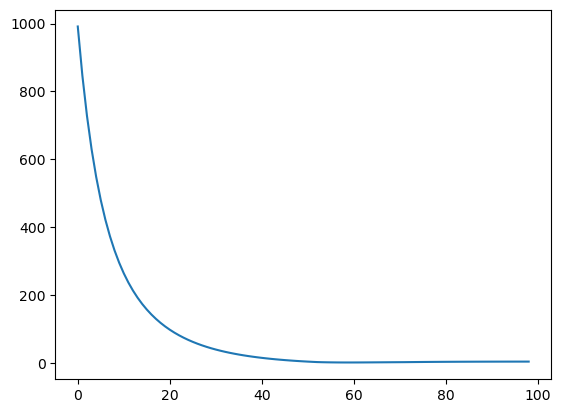

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe1a274cf70>

In [49]:
plot(maxV)

Looking at the spatial pattern of velocities... note the changing colorbar.

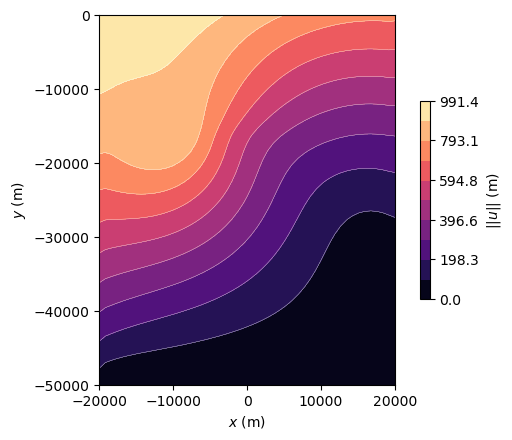

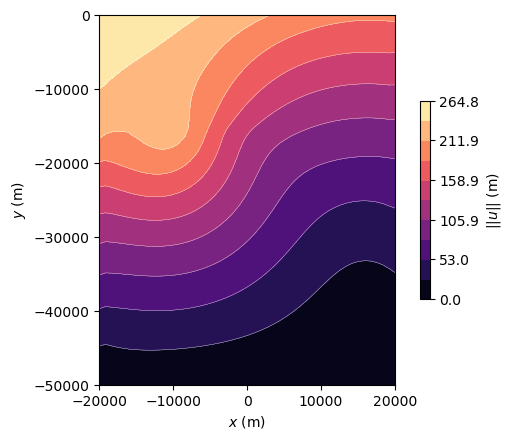

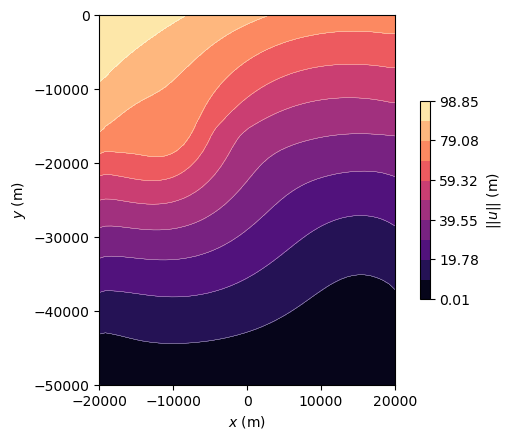

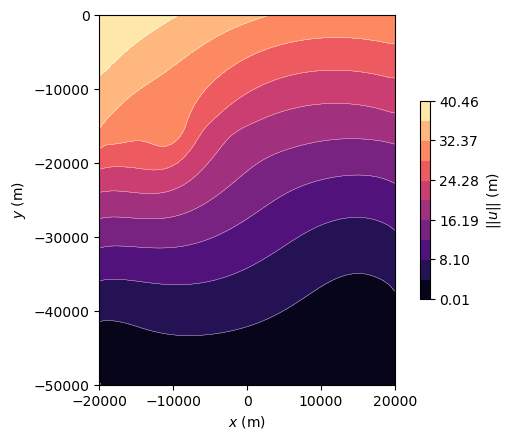

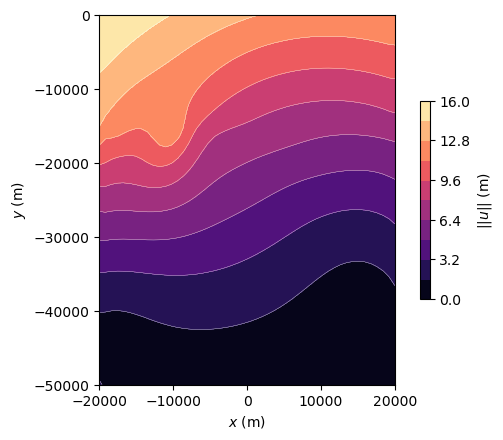

In [41]:
for i in 1:10:41
    figure()
    field = sqrt.(Vhistory[:, 1, i].^2 + Vhistory[:, 2, i].^2)
    ncontours = 10
    lowfield = minimum(field)
    highfield = maximum(field)
    ncontours = LinRange(lowfield, highfield, 11)    

    xlim = [-20000 20000]
    scale = 1.0
    fieldmax = maximum(@.abs(field))
    contourf(reshape(xgrid, npts, npts), reshape(ygrid, npts, npts),
             reshape(field, npts, npts), ncontours,
             vmin=lowfield, vmax=highfield,
             cmap = get_cmap("magma"))
    clim(lowfield, highfield)
    colorbar(fraction=0.020, pad=0.05, extend = "both", label = L"$||u||$ (m)")
    contour(reshape(xgrid, npts, npts), reshape(ygrid, npts, npts),
            reshape(field, npts, npts), ncontours,
            vmin=lowfield, vmax=highfield,
            linewidths=0.25, colors="w")
    gca().set_aspect("equal")
    gca().set_xlim([-20000, 20000])
    gca().set_ylim([-50000, 0])
    xlabel(L"$x$ (m)")
    ylabel(L"$y$ (m)")
end

But, there are problems that eventually show up. Eventually the log velocity starts rising again, which is a numerical artifact. I think this is due to the edge effects occuring in the FEM solution where the elements cross the BEM solution. I think this is solvable, but in the meantime, it's probably a tolerable issue given that the scale is 5-10 on a baseline effect size of 1000. So, it's essentially a 1% error. It's probably also improvable by using denser meshes.

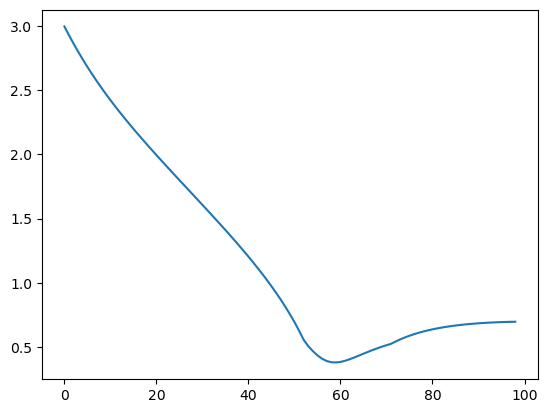

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe1a3360fd0>

In [51]:
plot(log10.(maxV))